C:\Users\david\AppData\Local\Temp\ipykernel_14840\3491515981.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_td = pd.read_sql(query_td, conn)
C:\Users\david\AppData\Local\Temp\ipykernel_14840\3491515981.py:55: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_area = pd.read_sql(query_area, conn)
C:\Users\david\AppData\Local\Temp\ipykernel_14840\3491515981.py:108: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby

CSV guardado: ./scores_tempDelta_norm__desastres_por_area_norm.csv
Países con score: 233


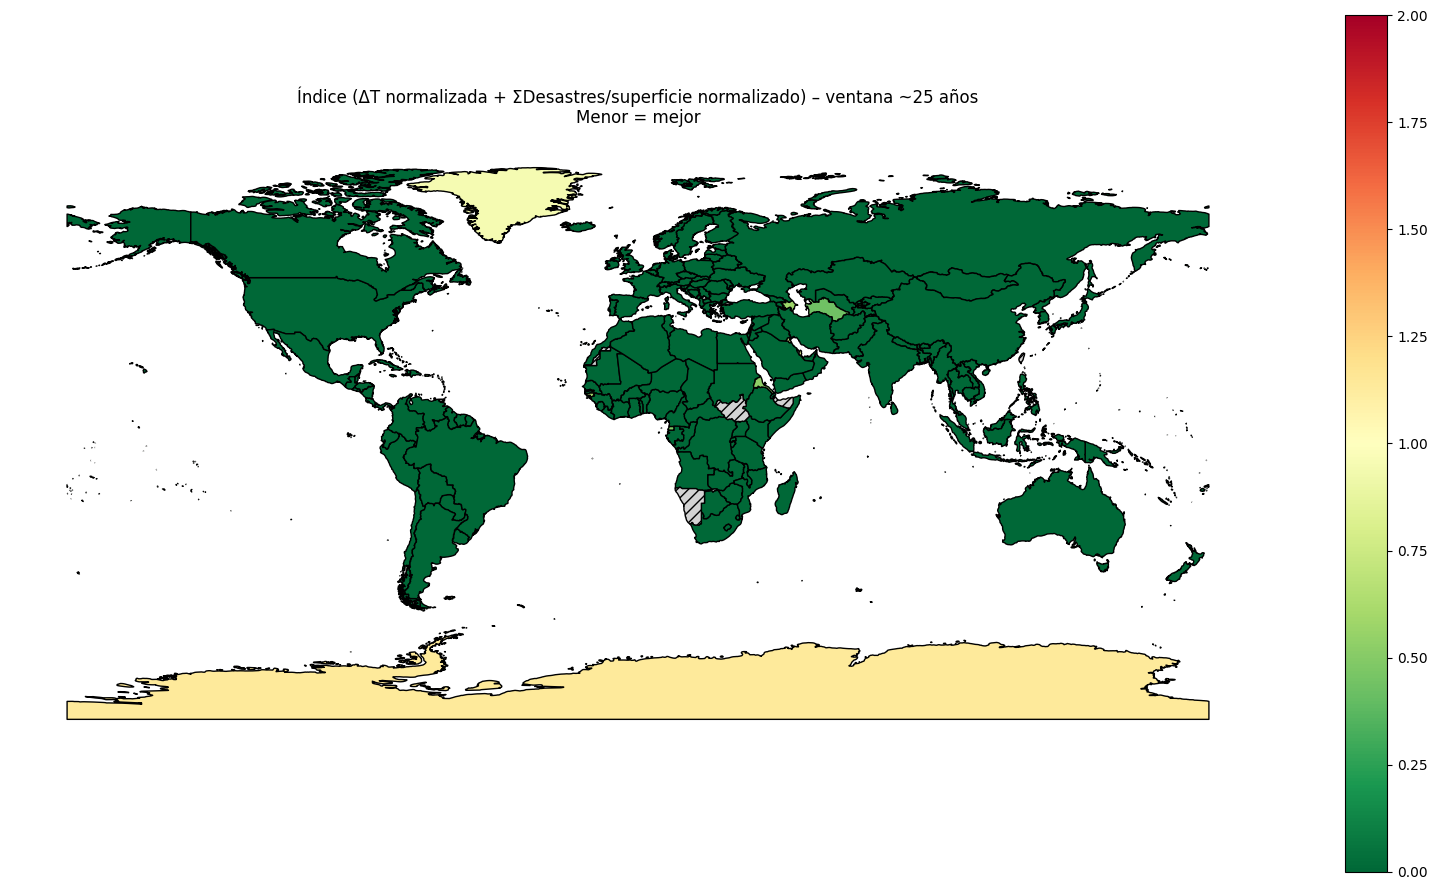

In [16]:
import os
import numpy as np
import pandas as pd
import pymysql
import geopandas as gpd
import matplotlib.pyplot as plt
import pycountry
from dotenv import load_dotenv

# ========== Parámetros ==========
N = 25              # ventana de años
MIN_YEARS = 2       # mínimo de años en la ventana
SHAPEFILE = "./../../data/visualizacion/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"

# ============== Conexión a BD ==============
load_dotenv()
conn = pymysql.connect(
    host=os.getenv('DB_HOST'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    database=os.getenv('DB_NAME')
)

# ==============================
# 1) Traer temperatura y desastres
# ==============================
query_td = """
SELECT 
    h.anio                           AS Year,
    p.codigo                         AS iso2,
    p.nombre                         AS pais_nombre,
    i.codigo                         AS indicador_codigo,
    h.valor                          AS valor
FROM hechos h
JOIN paises p      ON p.codigo = h.pais_id
JOIN indicadores i ON i.id = h.indicador_id
WHERE i.codigo IN ('temperaturas', 'desastres_total')
"""
df_td = pd.read_sql(query_td, conn)
df_td["Year"] = df_td["Year"].astype(int)

# ==============================
# 2) Traer SUPERFICIE (AG.LND.TOTL.K2)
# ==============================
query_area = """
SELECT 
    p.codigo AS iso2,
    MAX(h.valor) AS area_km2
FROM hechos h
JOIN indicadores i ON i.id = h.indicador_id
JOIN paises p      ON p.codigo = h.pais_id
WHERE i.codigo = 'AG.LND.TOTL.K2'
GROUP BY p.codigo
"""
df_area = pd.read_sql(query_area, conn)

# ==============================
# 3) Pivot por país-año y unir área
# ==============================
df_pivot = df_td.pivot_table(
    index=["Year", "iso2", "pais_nombre"],
    columns="indicador_codigo",
    values="valor",
    aggfunc="sum"
).reset_index()

df_pivot.rename(columns={
    "temperaturas": "Temperatura",
    "desastres_total": "Desastres"
}, inplace=True)

df_pivot = df_pivot.merge(df_area, on="iso2", how="left").sort_values(["iso2", "Year"])

# ==============================
# 4) Cálculo por país
# ==============================
def compute_country(g):
    g = g.sort_values("Year")
    if g.empty:
        return pd.Series({"DeltaT": np.nan, "Des_rate": np.nan})

    y_end = g["Year"].max()
    y_start = y_end - (N - 1)
    win = g[g["Year"].between(y_start, y_end)].copy()
    if win.empty or len(win["Year"].unique()) < MIN_YEARS:
        return pd.Series({"DeltaT": np.nan, "Des_rate": np.nan})

    y_first, y_last = win["Year"].min(), win["Year"].max()

    # ΔT
    delta_t = np.nan
    if "Temperatura" in win.columns:
        T0 = win.loc[win["Year"] == y_first, "Temperatura"].mean()
        T1 = win.loc[win["Year"] == y_last,  "Temperatura"].mean()
        if not pd.isna(T0) and not pd.isna(T1):
            delta_t = T1 - T0

    # ΣDesastres / superficie
    des_rate = np.nan
    if "Desastres" in win.columns and "area_km2" in win.columns:
        area = win["area_km2"].dropna().iloc[0] if win["area_km2"].notna().any() else np.nan
        if not pd.isna(area) and area > 0:
            des_sum = win["Desastres"].fillna(0).sum()
            des_rate = des_sum / area

    return pd.Series({"DeltaT": delta_t, "Des_rate": des_rate})

df_comp = df_pivot.groupby(["iso2","pais_nombre"], as_index=False).apply(compute_country)

# ==============================
# 5) Normalizar ΔT y Des_rate (min–max global)
# ==============================
df_valid = df_comp.copy()

# ΔT
if df_valid["DeltaT"].notna().any():
    t_min, t_max = df_valid["DeltaT"].min(), df_valid["DeltaT"].max()
    df_valid["Temp_norm_0_1"] = (df_valid["DeltaT"] - t_min) / (t_max - t_min) if t_max > t_min else 0.5

# Desastres/km²
if df_valid["Des_rate"].notna().any():
    d_min, d_max = df_valid["Des_rate"].min(), df_valid["Des_rate"].max()
    df_valid["Des_norm_0_1"] = (df_valid["Des_rate"] - d_min) / (d_max - d_min) if d_max > d_min else 0.5

# ==============================
# 6) Score final (si falta una, la otra cuenta doble)
# ==============================
def combine_score(row):
    t, d = row.get("Temp_norm_0_1", np.nan), row.get("Des_norm_0_1", np.nan)
    if pd.notna(t) and pd.notna(d):
        return t + d
    elif pd.notna(t):
        return 2 * t
    elif pd.notna(d):
        return 2 * d
    else:
        return np.nan

df_valid["Score"] = df_valid.apply(combine_score, axis=1)
df_valid = df_valid[df_valid["Score"].notna()].copy()
df_valid["Score_0_100"] = 50 * df_valid["Score"]

# ==============================
# 7) ISO2 -> ISO3 y guardar
# ==============================
def iso2_to_iso3(code):
    try: return pycountry.countries.get(alpha_2=code).alpha_3
    except: return None

df_valid["iso_a3"] = df_valid["iso2"].apply(iso2_to_iso3)
df_scores = df_valid[df_valid["iso_a3"].notna()].copy()
df_scores["iso_a3"] = df_scores["iso_a3"].str.upper()

out_csv = "./scores_tempDelta_norm__desastres_por_area_norm.csv"
df_scores.to_csv(out_csv, index=False)
print(f"CSV guardado: {out_csv}")
print("Países con score:", df_scores.shape[0])

# ==============================
# 8) Mapa
# ==============================
world = gpd.read_file(SHAPEFILE)
shape_key = next(k for k in ["ADM0_A3","ISO_A3_EH","ISO_A3"] if k in world.columns)
world[shape_key] = world[shape_key].astype(str).str.upper()

map_data = world.merge(df_scores, left_on=shape_key, right_on="iso_a3", how="left")

fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title(
    f"Índice (ΔT normalizada + ΣDesastres/superficie normalizado) – ventana ~{N} años\nMenor = mejor",
    pad=12
)

map_data.plot(
    column="Score",
    legend=True,
    ax=ax,
    edgecolor="black",
    cmap="RdYlGn_r",
    vmin=0, vmax=2,
    missing_kwds={"color": "lightgrey", "hatch": "///", "label": "Sin datos"}
)

ax.axis("off")
plt.tight_layout()
plt.show()


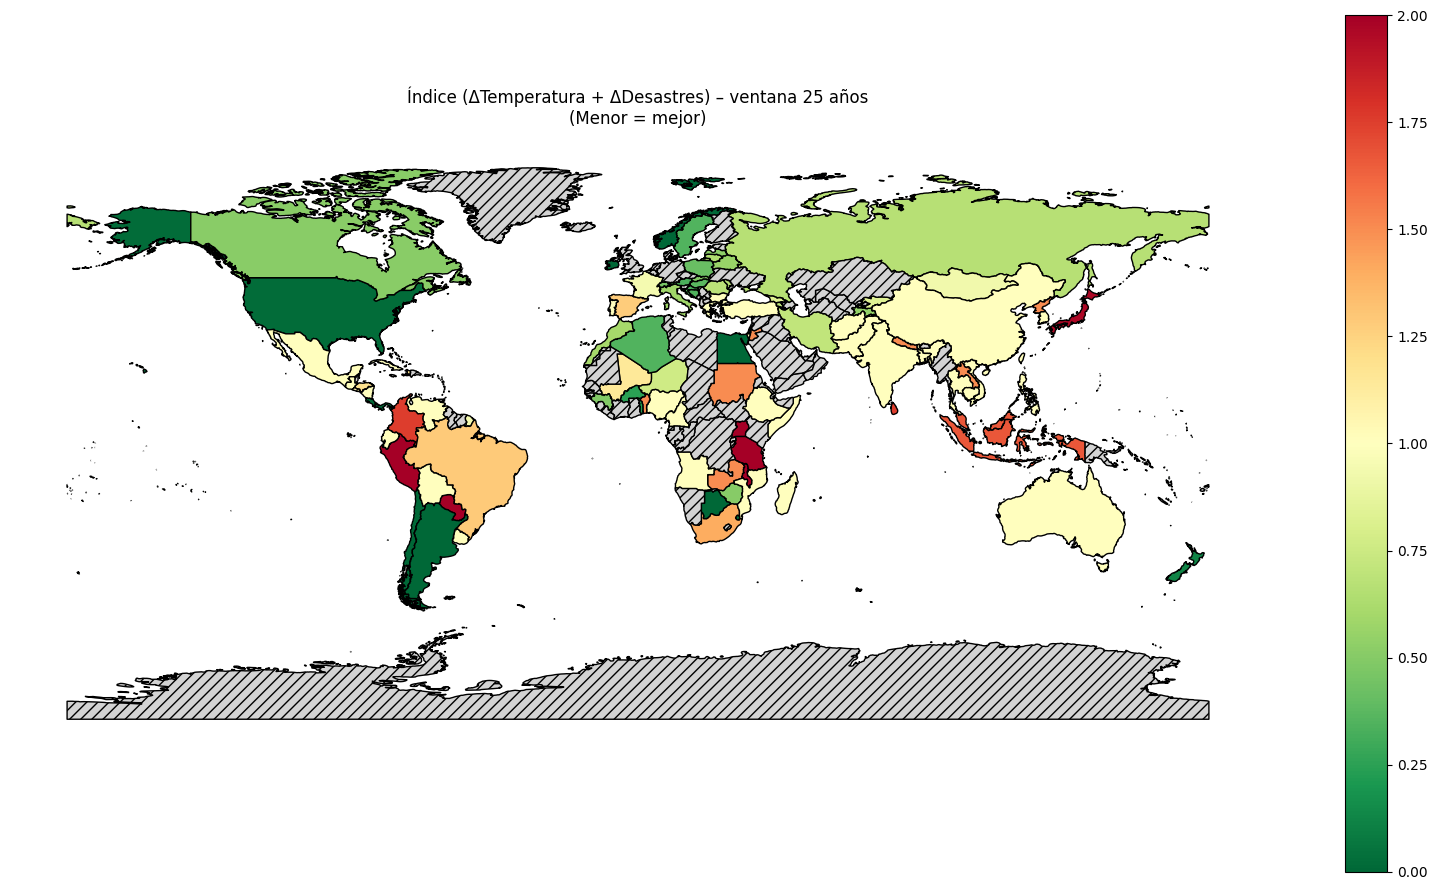

In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pycountry

# =======================
# 1) Cargar CSV generado
# =======================
csv_path = "./scores_temp_desastres.csv"
df_scores = pd.read_csv(csv_path)

# Normalizar códigos
df_scores["iso_a3"] = df_scores["iso_a3"].astype(str).str.upper()

# =======================
# 2) Cargar shapefile
# =======================
SHAPEFILE = "./../../data/visualizacion/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"
world = gpd.read_file(SHAPEFILE)

# Seleccionar clave correcta del shapefile
shape_key_candidates = ["ADM0_A3", "ISO_A3_EH", "ISO_A3"]
for k in shape_key_candidates:
    if k in world.columns:
        shape_key = k
        break
world[shape_key] = world[shape_key].astype(str).str.upper()

# =======================
# 3) Merge robusto
# =======================
map_data = world.merge(df_scores, left_on=shape_key, right_on="iso_a3", how="left")

# =======================
# 4) Pintar mapa
# =======================
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title("Índice (ΔTemperatura + ΔDesastres) – ventana 25 años\n(Menor = mejor)", pad=12)

map_data.plot(
    column="Score",          # Score calculado
    legend=True,
    ax=ax,
    edgecolor="black",
    cmap="RdYlGn_r",         # verde (bajo) → rojo (alto)
    vmin=0, vmax=2,
    missing_kwds={"color": "lightgrey", "hatch": "///", "label": "Sin datos"},
)

ax.axis("off")
plt.tight_layout()
plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_19692\1969219738.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(query_td, conn)
C:\Users\david\AppData\Local\Temp\ipykernel_19692\1969219738.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_area = pd.read_sql(query_area, conn)
C:\Users\david\AppData\Local\Temp\ipykernel_19692\1969219738.py:158: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupb

Países totales: 189
Países con datos válidos (antes de normalizar): 106
CSV guardado: ./scores_tempSUM_norm__desastres_per_area_FROM_MAXAREA_ROBUST.csv
Países en CSV final: 106


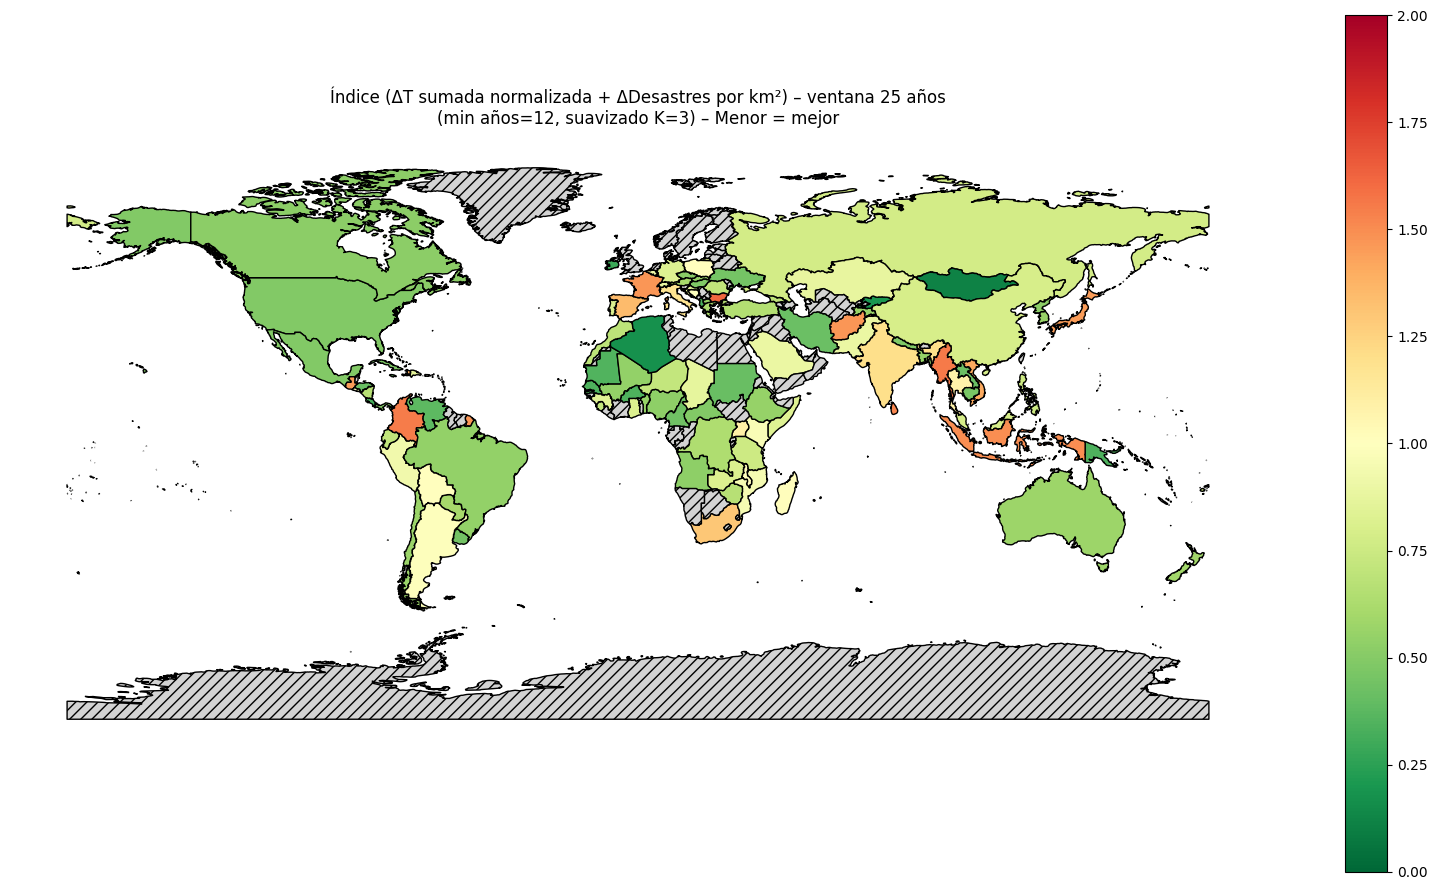

In [17]:
import os
import numpy as np
import pandas as pd
import pymysql
import geopandas as gpd
import matplotlib.pyplot as plt
import pycountry
from dotenv import load_dotenv

# ======================
# Parámetros
# ======================
N = 25                 # ventana objetivo (años)
MIN_YEARS = 12         # mínimo de años requeridos dentro de la ventana
K_SMOOTH = 3           # media de primeros/últimos K años para desastres
CLIP = True            # recortar componentes a [0,1]
EPS_DES = 1.0          # smoothing contra ceros en desastres/área
SHAPEFILE = "./../../data/visualizacion/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"

# Códigos de indicadores
TEMP_VAR_CODE = "temperaturas_var"   # ΔT anual si existe
TEMP_LVL_CODE = "temperaturas"       # nivel de T (fallback para derivar ΔT)
DESASTRES_CODE = "desastres_total"   # nº de desastres

# ==============
# Conexión a BD
# ==============
load_dotenv()
conn = pymysql.connect(
    host=os.getenv('DB_HOST'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    database=os.getenv('DB_NAME')
)

# ===========================================================
# 1) Datos de temperatura y desastres
# ===========================================================
query_td = f"""
SELECT 
    h.anio  AS Year,
    p.codigo AS iso2,
    p.nombre AS pais_nombre,
    i.codigo AS indicador_codigo,
    h.valor  AS valor
FROM hechos h
JOIN paises p      ON p.codigo = h.pais_id
JOIN indicadores i ON i.id = h.indicador_id
WHERE i.codigo IN ('{TEMP_VAR_CODE}', '{TEMP_LVL_CODE}', '{DESASTRES_CODE}')
"""
df_raw = pd.read_sql(query_td, conn)
df_raw["Year"] = df_raw["Year"].astype(int)

# ===========================================================
# 2) Superficie: UNA por país (tu consulta)
# ===========================================================
query_area = """
SELECT 
    h.pais_id AS iso2,
    MAX(h.valor) AS Area_km2
FROM tfm_cambio_climatico.hechos h
WHERE h.indicador_id = 10
GROUP BY h.pais_id
"""
df_area = pd.read_sql(query_area, conn)

# ===========================================================
# 3) Pivot y ΔT
# ===========================================================
df_piv = df_raw.pivot_table(
    index=["Year", "iso2", "pais_nombre"],
    columns="indicador_codigo",
    values="valor",
    aggfunc="mean"
).reset_index()

rename_map = {}
if TEMP_VAR_CODE in df_piv.columns: rename_map[TEMP_VAR_CODE] = "TempVar"
if TEMP_LVL_CODE in df_piv.columns: rename_map[TEMP_LVL_CODE] = "TempNivel"
if DESASTRES_CODE in df_piv.columns: rename_map[DESASTRES_CODE] = "Desastres"
df_piv.rename(columns=rename_map, inplace=True)

# ΔT si no viene de BD: derivar desde nivel
if "TempVar" not in df_piv.columns:
    if "TempNivel" not in df_piv.columns:
        raise ValueError("No hay 'temperaturas_var' ni 'temperaturas' para derivar ΔT.")
    df_piv = df_piv.sort_values(["iso2", "Year"]).copy()
    df_piv["TempVar"] = df_piv.groupby("iso2")["TempNivel"].diff()

# Unir superficie
df_piv = df_piv.merge(df_area, on="iso2", how="left")

# Necesarios para seguir
df_piv = df_piv.dropna(subset=["TempVar", "Desastres", "Area_km2"])

# ===========================================================
# 4) Cálculo por país (robusto a huecos)
# ===========================================================
def clip01(x): 
    return max(0.0, min(1.0, x))

def country_components(g):
    g = g.sort_values("Year")
    y_end = g["Year"].max()
    y_start = y_end - (N - 1)
    win = g[g["Year"].between(y_start, y_end)].copy()

    # si hay pocos datos, nos salimos
    if win["Year"].nunique() < MIN_YEARS:
        return pd.Series({
            "Temp_sum_N": np.nan,
            "Des_per_area_change": np.nan,
            "YearStart": y_start, "YearEnd": y_end,
            "YearsAvail": win["Year"].nunique()
        })

    # --- Temperatura: suma ΔT de los años disponibles en la ventana ---
    temp_sum = win["TempVar"].dropna().sum()

    # --- Área km² (constante por país en nuestra tabla agregada) ---
    A = g["Area_km2"].dropna()
    A = A.iloc[0] if not A.empty else np.nan
    if pd.isna(A) or A <= 0:
        return pd.Series({
            "Temp_sum_N": temp_sum,
            "Des_per_area_change": np.nan,
            "YearStart": y_start, "YearEnd": y_end,
            "YearsAvail": win["Year"].nunique()
        })

    # --- Desastres por km²: usar primeros/últimos K años DISPONIBLES de la ventana ---
    win_years = sorted(win["Year"].unique())
    first_years = win_years[:min(K_SMOOTH, len(win_years))]
    last_years  = win_years[-min(K_SMOOTH, len(win_years)):]

    D_first = win[win["Year"].isin(first_years)]["Desastres"].mean()
    D_last  = win[win["Year"].isin(last_years)]["Desastres"].mean()

    if pd.isna(D_first) or pd.isna(D_last):
        d_change = np.nan
    else:
        D0_pa = (D_first + EPS_DES) / A
        D1_pa = (D_last  + EPS_DES) / A
        d_change = (D1_pa - D0_pa) / D0_pa
        if CLIP:
            d_change = clip01(d_change)
        else:
            d_change = max(0.0, d_change)

    return pd.Series({
        "Temp_sum_N": temp_sum,
        "Des_per_area_change": d_change,
        "YearStart": y_start, "YearEnd": y_end,
        "YearsAvail": win["Year"].nunique()
    })

df_comp = (
    df_piv
    .groupby(["iso2", "pais_nombre"], as_index=False)
    .apply(country_components)
)

print("Países totales:", df_comp["iso2"].nunique())
print("Países con datos válidos (antes de normalizar):", df_comp.dropna(subset=["Temp_sum_N","Des_per_area_change"])["iso2"].nunique())

# ===========================================================
# 5) Normalización min–max de Temp_sum_N a 0..1 (global)
# ===========================================================
df_valid = df_comp.dropna(subset=["Temp_sum_N", "Des_per_area_change"]).copy()

min_s = df_valid["Temp_sum_N"].min()
max_s = df_valid["Temp_sum_N"].max()
den = max_s - min_s
df_valid["Temp_norm_0_1"] = 0.5 if den == 0 else (df_valid["Temp_sum_N"] - min_s) / den

# ===========================================================
# 6) Score final y export
# ===========================================================
df_valid["Score"] = df_valid["Temp_norm_0_1"] + df_valid["Des_per_area_change"]
df_valid["Score_0_100"] = 50 * df_valid["Score"]

# ISO2 -> ISO3 para mapa
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

df_valid["iso_a3"] = df_valid["iso2"].apply(iso2_to_iso3)
df_scores = df_valid[df_valid["iso_a3"].notna()].copy()
df_scores["iso_a3"] = df_scores["iso_a3"].str.upper()

# Export
out_csv = "./scores_tempSUM_norm__desastres_per_area_FROM_MAXAREA_ROBUST.csv"
df_scores.to_csv(out_csv, index=False)
print(f"CSV guardado: {out_csv}")
print("Países en CSV final:", df_scores["iso_a3"].nunique())

# ===========================================================
# 7) Mapa mundial
# ===========================================================
world = gpd.read_file(SHAPEFILE)

shape_key_candidates = ["ADM0_A3", "ISO_A3_EH", "ISO_A3"]
for k in shape_key_candidates:
    if k in world.columns:
        shape_key = k
        break
world[shape_key] = world[shape_key].astype(str).str.upper()

map_data = world.merge(df_scores, left_on=shape_key, right_on="iso_a3", how="left")

fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title(
    f"Índice (ΔT sumada normalizada + ΔDesastres por km²) – ventana {N} años\n"
    f"(min años={MIN_YEARS}, suavizado K={K_SMOOTH}) – Menor = mejor",
    pad=12
)

map_data.plot(
    column="Score",
    legend=True,
    ax=ax,
    edgecolor="black",
    cmap="RdYlGn_r",
    vmin=0, vmax=2,
    missing_kwds={"color": "lightgrey", "hatch": "///", "label": "Sin datos"}
)

ax.axis("off")
plt.tight_layout()
plt.show()
